In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [3]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Processing...
Done!


In [0]:
from torch import nn,optim
import torch.nn.functional as F

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)
    
  def forward(self,x):
    
    # make sure input tensor is flattened
    x = x.view(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)
        
    return x   

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define though. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are precision and recall) and top-5 error rate. We'll focus on accuracy here. First I'll do a forward pass with one batch from the test set.

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [6]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[8],
        [8],
        [1],
        [8],
        [1],
        [8],
        [8],
        [1],
        [8],
        [1]])


In [0]:
equals = top_class == labels.view(*top_class.shape)

In [8]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 9.375%


In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.512..  Test Loss: 0.494..  Test Accuracy: 0.813
Epoch: 2/30..  Training Loss: 0.394..  Test Loss: 0.423..  Test Accuracy: 0.848
Epoch: 3/30..  Training Loss: 0.362..  Test Loss: 0.404..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.334..  Test Loss: 0.394..  Test Accuracy: 0.856
Epoch: 5/30..  Training Loss: 0.316..  Test Loss: 0.403..  Test Accuracy: 0.859
Epoch: 6/30..  Training Loss: 0.305..  Test Loss: 0.376..  Test Accuracy: 0.865
Epoch: 7/30..  Training Loss: 0.292..  Test Loss: 0.367..  Test Accuracy: 0.871
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.350..  Test Accuracy: 0.878
Epoch: 9/30..  Training Loss: 0.276..  Test Loss: 0.417..  Test Accuracy: 0.859
Epoch: 10/30..  Training Loss: 0.271..  Test Loss: 0.378..  Test Accuracy: 0.871
Epoch: 11/30..  Training Loss: 0.261..  Test Loss: 0.371..  Test Accuracy: 0.877
Epoch: 12/30..  Training Loss: 0.252..  Test Loss: 0.362..  Test Accuracy: 0.882
Epoch: 13/30..  Training Loss: 0.246.

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

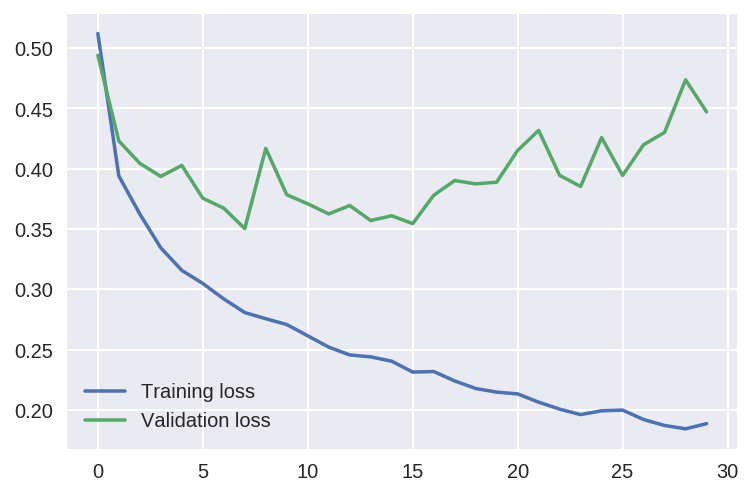

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)